In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import surprise

## Import data from processed database


In [15]:
#Set up data
path = '/db/wrangled_reviews.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT customer_id, product_id, product_title, product_parent, star_rating, helpful_votes, 
                review_word_count, review_hl_count, cleaned_sentiment_star_rating, difference
                FROM processed
                ;
                ''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type  


    return df

df = import_data(path)

In [9]:
df.head(5)

,customer_id,product_id,product_parent,star_rating,helpful_votes,review_word_count,review_hl_count,cleaned_sentiment_star_rating,difference
0,40676812,1938067126,402004849,5,0,1,2,5.000000,0.000000
1,2784618,014017737X,779170984,5,0,8,2,3.000000,2.000000
2,2876528,0982207743,225126623,3,1,10,2,2.000000,1.000000
3,33678379,080072433X,42136245,3,0,277,4,3.009420,0.009420
4,32159651,0615815650,625464646,3,1,22,4,2.636364,0.363636


In [10]:
len(df)
df.dtypes

customer_id                        int64
product_id                        object
product_parent                     int64
star_rating                        int64
helpful_votes                      int64
review_word_count                  int64
review_hl_count                    int64
cleaned_sentiment_star_rating    float64
difference                       float64
dtype: object

# YellowBrick Viz SKIP


In [12]:
from yellowbrick.features import Rank2D
%matplotlib inline

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df)
visualizer.poof()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


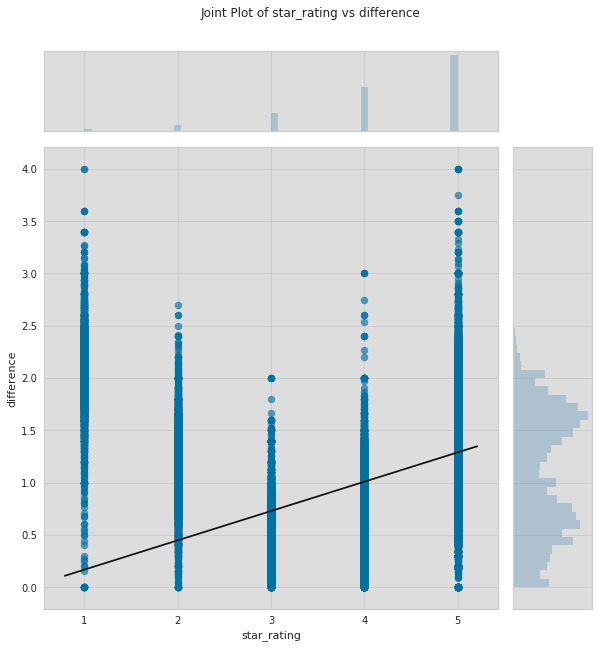

In [13]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='star_rating', target='difference')
visualizer.fit(df['star_rating'], df['difference'])
visualizer.poof()

In [ ]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='sentiment_star_rating', target='cleaned_sentiment_star_rating')
visualizer.fit(X_dat['sentiment_star_rating'], X_dat['cleaned_sentiment_star_rating'])
visualizer.poof()

In [ ]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='sentiment_star_rating', target='star_rating')
visualizer.fit(X_dat['sentiment_star_rating'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['sentiment_star_rating'], X_dat['star_rating'])


In [ ]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='cleaned_sentiment_star_rating', target='star_rating')
visualizer.fit(X_dat['cleaned_sentiment_star_rating'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['cleaned_sentiment_star_rating'], X_dat['star_rating'])


In [ ]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='difference', target='star_rating')
visualizer.fit(X_dat['difference'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['difference'], X_dat['star_rating'])

## Clustering  SKIP

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(4,12))

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

# Modeling in Sci-Kit Learn

### SVD 

In [47]:
def SVD(data):
    
    from scipy.sparse import csr_matrix
    from sklearn.decomposition import TruncatedSVD
    df = data
    df_pivot = df.pivot_table(index='customer_id',columns='product_title',values='star_rating',fill_value=0)
    X = df_pivot.T
    SVD = TruncatedSVD(n_components=12, random_state=17)
    matrix = SVD.fit_transform(X)
    corr = np.corrcoef(matrix)
    book_title = df_pivot.columns
    book_list = book_title.tolist()
    book_title = np.asarray(book_title)

In [48]:
SVD(df)

MemoryError: 

In [46]:
def print_recs(title):
    

    book_idx = book_list.index(title)
    corr_target = corr[book_idx]
    corrs = np.concatenate((book_title,corr_target),axis=0)

    top_5_idx = np.argsort(corr_target)[-6:-1]
    top_5_values = [book_title[i] for i in top_5_idx]
    print(top_5_values)


print_recs("The Stand")

['The Dark Tower V: The Wolves of the Calla (The Dark Tower, Book 5)', 'Atlas Shrugged', 'The Terror: A Novel', 'The Odyssey', "'Salem's Lot"]


# Modeling in Suprise

In [ ]:
from surprise import Reader, Dataset

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(df.product_id),
                'userID': list(df.customer_id),
                'rating': list(df.star_rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [ ]:
###Using Suprise package
# Split data into 5 folds

data.split(n_folds=5)

from surprise import SVD, evaluate
from surprise import NMF, model_selection

# svd
algo = SVD()
svd_mod = model_selection.cross_validate(algo, data, measures=['RMSE'])
svd_mod.fit()




In [ ]:
# nmf
algo = NMF()
nmf_mod = model_selection.cross_validate(algo, data, measures=['RMSE'])
nmf_mod.fit()